In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt
import random
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

from utils import *

from models import * 
import torch.optim as optim

from sklearn import preprocessing

from Experiments import *

seed = 0 

def set_seeds(seed): 
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 

set_seeds(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

%load_ext autoreload
%autoreload 2


cuda


In [291]:
# data_file = "traffic_data/data.csv"
# hier_file = "traffic_data/agg_mat.csv"
# data = pd.read_csv(data_file, index_col=0)
# agg_mat_df = pd.read_csv(hier_file, index_col=0)
# base_agg_mat = agg_mat_df.values

data_file = "tourism_data/data.csv"
hier_file = "tourism_data/agg_mat.csv"

# data_file = "labor/data.csv"
# hier_file = "labor/agg_mat.csv"

data = pd.read_csv(data_file, index_col=0)
agg_mat_df = pd.read_csv(hier_file, index_col=0)
base_agg_mat = agg_mat_df.values
full_agg = format_aggregation_matrix(base_agg_mat).float().to(device)

maximum = np.max(data.values)
data = (data / maximum).values

batch_size = 64
context_window = 10
train_split = 0.8
val_split = 0.01

num_runs = 1
n_epochs = 5000

X_train, y_train, X_val, y_val, X_test, y_test = utils.get_data(data, train_split, val_split, context_window)

In [287]:
def cvae_loss(y, y_pred, mean, logvar):
    reconstruction_loss = torch.square(y_pred - y) 
    return reconstruction_loss.mean()
    # kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    # return reconstruction_loss + kl_loss

class CVAE(nn.Module):
    def __init__(self, aggregate_mat, params):
        super(CVAE, self).__init__()
        self.latent_dim = params['latent_dim']
        input_dim = params['n_series']
        hidden_dim = params['hidden_dim']        

        # RNN Encoder
        self.encoder_rnn = RNN(input_dim, hidden_dim, aggregate_mat, params)
        self.encoder_fc = nn.Linear(hidden_dim, self.latent_dim * 2)

        # Decoder
        self.decoder_fc1 = nn.Linear(self.latent_dim + hidden_dim, hidden_dim)
        self.last_layer = nn.Linear(hidden_dim, input_dim)
        
    def encode(self, x):
        h = self.encoder_rnn(x, get_hidden=True)
        mean, logvar = torch.chunk(self.encoder_fc(h), 2, dim=-1)
        return mean, logvar, h

    def reparameterize(self, mean, logvar):
        # std = torch.exp(0.5 * logvar)
        # std = torch.exp(0.5 * torch.ones_like(logvar).to(device))
        std = torch.ones_like(logvar).to(device) * 0.5
        eps = torch.randn_like(std)
        return eps * std + mean

    def decode(self, z, h):
        xz = torch.cat((z, h), -1)
        h = torch.relu(self.decoder_fc1(xz))
        y_pred = self.last_layer(h)
        return y_pred.squeeze(-1)
    
    def forward(self, x):
        mu, logvar, h = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, h), mu, logvar


In [335]:
params = {'n_series':data.shape[1], 'hidden_dim':128, 'latent_dim':128, 'lr':1e-4, 'n_epochs':10000, 'batch_size':16, 'train_split':train_split, 'val_split':val_split, 'context_window':context_window, 'aggregate':False,
          'coherency_loss':True, 'profhit':False, 'coherency_weight':1, 'project':False}

model = CVAE(base_agg_mat, params).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Dummy data
# batch_size = 16
# sequence_length = 5

# Training loop
losses = [1]
# for epoch in range(1000):
#     model.train()
#     optimizer.zero_grad()
#     y_pred, mean, logvar = model(X_train.float().to(device))
#     loss = cvae_loss(y_train.to(device).float(), y_pred, mean, logvar)
#     loss.backward()
#     optimizer.step()
    
#     losses.append(loss.item())
#     if epoch % 50 == 0:
#         print(f"Epoch {epoch}, Loss: {loss.item()}")

c_losses = [1]        
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    y_pred, mean, logvar = model(X_train.float().to(device))
    r_loss = cvae_loss(y_train.to(device).float(), y_pred, mean, logvar)
    c_loss = coherency.coherency_loss(model, torch.tensor(full_agg).to(device).float())
    loss = r_loss * np.mean(c_losses) / np.mean(losses) + c_loss * params['coherency_weight']
    loss.backward()
    optimizer.step()
    
    losses.append(r_loss.item())
    c_losses.append(c_loss.item())

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {r_loss.item(), c_loss.item()}")

/tmp/ipykernel_63560/2695553304.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c_loss = coherency.coherency_loss(model, torch.tensor(full_agg).to(device).float())


Epoch 0, Loss: (0.01905084401369095, 31.250329971313477)
Epoch 50, Loss: (0.006601759698241949, 24.349254608154297)
Epoch 100, Loss: (0.003660369198769331, 20.385942459106445)
Epoch 150, Loss: (0.002404790371656418, 17.32329559326172)
Epoch 200, Loss: (0.0016650146571919322, 14.801379203796387)
Epoch 250, Loss: (0.0012317998334765434, 12.645777702331543)
Epoch 300, Loss: (0.0008884940179996192, 10.74744987487793)
Epoch 350, Loss: (0.0006176108727231622, 9.047368049621582)
Epoch 400, Loss: (0.0004096867924090475, 7.513579845428467)
Epoch 450, Loss: (0.0002724889782257378, 6.1314263343811035)
Epoch 500, Loss: (0.00016988681454677135, 4.894115924835205)
Epoch 550, Loss: (0.00011674521374516189, 3.7966654300689697)
Epoch 600, Loss: (9.441587462788448e-05, 2.8319308757781982)
Epoch 650, Loss: (6.96117858751677e-05, 1.9906028509140015)
Epoch 700, Loss: (5.391895319917239e-05, 1.2639548778533936)
Epoch 750, Loss: (4.5016524381935596e-05, 0.6491639018058777)
Epoch 800, Loss: (3.863361416733824

In [336]:
def generate_samples(model, x, num_samples=100):
    model.eval() 
    with torch.no_grad():  
        mu, logvar, h = model.encode(x)
        
        samples = []
        for _ in range(num_samples):
            z = model.reparameterize(mu, logvar)
            sample = model.decode(z, h)
            samples.append(sample)
        
        samples = torch.stack(samples, dim=0)
    
    return samples

# Usage example
generated_samples = generate_samples(model, X_test.to(device).float(), num_samples=1000)

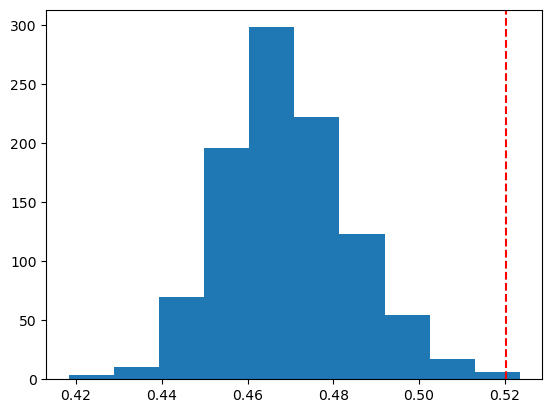

In [343]:
series = 0
index = 1
y1 = generated_samples[:,index,:]
plt.hist(y1[:,series].cpu(), bins=10)
plt.axvline(x=y_test[index,series], color='r', linestyle='--')

In [345]:
import properscoring as ps
crps_scores = []
for series in range(y_test.shape[1]):
    if series % 20 == 0:
        print(series)
    # score = utils.crps_sample(generated_samples[:, :, series].T, y_train[:,series].float().to(device)).cpu().numpy()
    score = ps.crps_ensemble(y_test[:,series], generated_samples[:, :, series].T.detach().cpu().numpy())
    crps_scores.append(score)
crps_scores = np.array(crps_scores)

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540


In [360]:
metrics = Metrics(full_agg)
np.mean(metrics.coherency_levels(_, generated_samples[20,:,:], y_test)[0])

0.0006059603351786791

In [285]:
y_pred = generated_samples.mean(0)
y_pred_std = generated_samples.std(0)
wmape_level(y_pred, y_test.float().to(device), torch.tensor(base_agg_mat, device=device))

[2.185678482055664,
 0.8098416328430176,
 0.7259135842323303,
 0.7550448775291443,
 0.5230386853218079,
 1.1977437734603882,
 1.6117966175079346,
 0.34830209612846375,
 0.3319043815135956,
 0.23865339159965515,
 0.38605237007141113,
 0.42425450682640076,
 0.39838117361068726,
 0.7042921781539917,
 0.38551098108291626,
 0.42789599299430847,
 0.2161073386669159,
 0.1476905792951584,
 0.24042923748493195,
 0.24005171656608582,
 0.268405944108963]

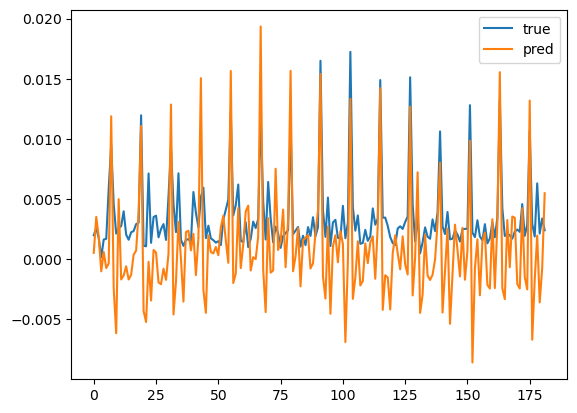

In [193]:
index=255
plt.plot(y_train[:,index], label='true')
# plt.errorbar(range(y_pred.shape[0]), y_pred[:, index].cpu(), y_pred_std[:, index].cpu())
plt.plot(range(y_pred.shape[0]), y_pred[:, index].cpu(), label='pred')
plt.legend()